In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import itertools

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Personnal Import 
from pipeline.plotting.plotting import plot_coverage_matshow
import numpy as np 
import pandas as pd
import torch
from pipeline.plotting.plotting import temporal_agg_for_matshow
# Load Tensors / dic :
T = 24*4*7 # One week 
N = 40
H = 1
stations = list(np.arange(N))
clustered_stations = {i: [j for j in range(i*10,(i+1)*10)] for i in range(4)}
index = pd.date_range(start='2022-01-01', periods=T, freq='15min')

# ---- Build Fake Errors df: 
dic_error_stations = {'datetime': index
                        }
for column in stations: 
    dic_error_stations.update({column: torch.randn(T).numpy()})
df_error_station = pd.DataFrame(dic_error_stations,columns = ['datetime']+stations,index = index)
# ----
df_error_station.head()

,datetime,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
2022-01-01 00:00:00,2022-01-01 00:00:00,-1.591796,0.088610,0.754401,-2.352190,0.730105,-0.316920,3.116603,0.849118,1.969190,...,0.318538,-0.975127,-1.430119,-1.130066,-0.648177,0.799639,-0.085711,4.195029,2.193355,-0.166552
2022-01-01 00:15:00,2022-01-01 00:15:00,0.428375,1.179708,1.239934,1.375528,-0.866942,-1.201678,1.232206,-0.339090,-0.850401,...,-1.051820,0.626430,-0.873160,-0.333232,-0.738960,-1.040924,-0.072300,-0.656257,0.162363,-0.408277
2022-01-01 00:30:00,2022-01-01 00:30:00,0.726835,0.558758,0.436178,0.559513,1.092775,-0.588306,-0.697449,-1.679396,-0.938854,...,-0.226578,0.585097,-0.296676,-1.277349,-0.476681,0.509084,-0.047473,0.592220,0.698792,1.194422
2022-01-01 00:45:00,2022-01-01 00:45:00,-0.224491,-0.569001,0.108366,-1.073154,1.037469,-0.104618,0.395704,0.394056,-0.011034,...,2.058996,-1.682585,1.629110,0.911844,0.053888,-0.093549,-1.076214,0.161307,0.407953,-0.938876
2022-01-01 01:00:00,2022-01-01 01:00:00,0.933434,1.020867,-0.797275,-1.099727,-0.809425,1.142961,-0.254568,0.235387,1.376813,...,-0.444723,0.118019,2.046803,-0.179972,0.205284,0.358106,-1.027178,-1.096140,-0.524444,-2.043081


Single temporal aggregation detected.
Nb x axes / Nb y axes: 1 / 3
Figsize: (40, 6)
Gridspec_kw: {'width_ratios': [10, 10, 10], 'height_ratios': [1]}


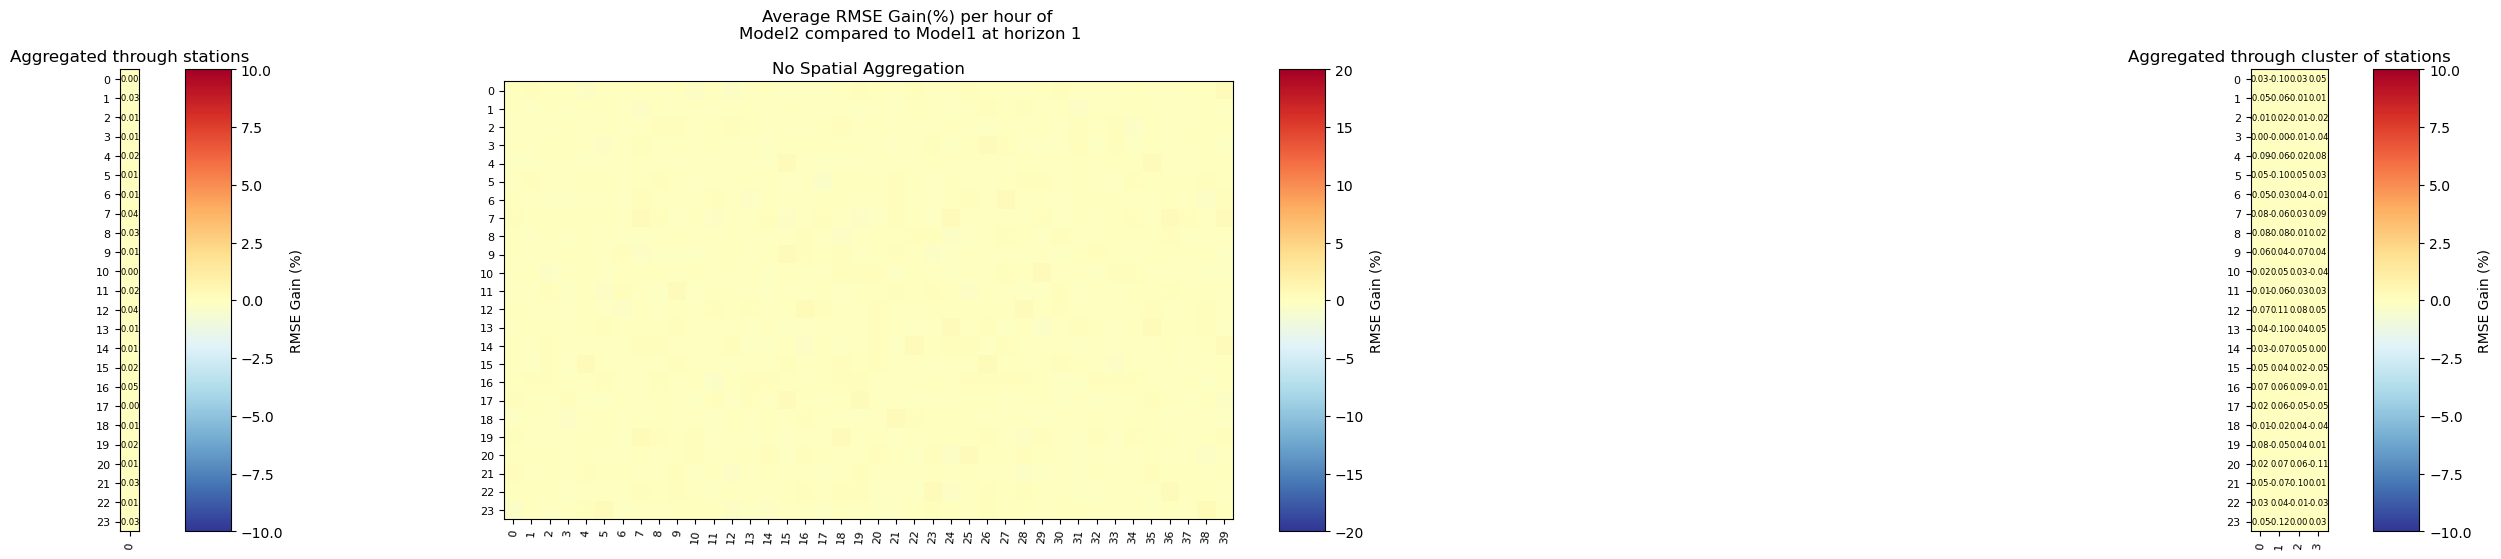

In [61]:
def get_df_mase_and_gains(df_error_station,index_matshow):
    df_gain21 = {}
    for column in stations: 
        gain_mase = temporal_agg_for_matshow(df_error_station,column,index_matshow,metric = None)
        df_gain21.update({column:gain_mase[column]})
    return df_gain21

class ComparisonPlotter:
    """
    Class to plot the gain between two models with different temporal aggregations.
    """
    def __init__(self, figsize_x=10, clustered_stations=None):
        self.figsize_x = figsize_x
        self.clustered_stations = clustered_stations  # dict of list of clustered stations if any, else None


    def _init_fig_axes_sizes(self,temporal_aggs):
        if self.clustered_stations is None: 
            nb_y_axes = 2
        else:
            nb_y_axes = 3

        # ---- Defines figsize and layouts: 
        width_ratios = WIDTH_RATIOS if self.clustered_stations is None else WIDTH_RATIOS_CLUSTER
        
        if len(temporal_aggs) == 1:
                gridspec_kw = {'width_ratios': width_ratios, 'height_ratios': HEIGHT_RATIOS}
                local_figsize = (self.figsize_x,6*len(temporal_aggs)*COEF_Y_SIZE)

                print("Single temporal aggregation detected.")
                print('Nb x axes / Nb y axes:',1, '/', nb_y_axes)
                print('Figsize:',local_figsize)
                print('Gridspec_kw:',gridspec_kw)
                fig, axes = plt.subplots(1, nb_y_axes, figsize=local_figsize,gridspec_kw=gridspec_kw)
        else:
            # Create a default height of 1 for all rows
            height_ratios = [1] * len(temporal_aggs)
            coef_y_size = 1

            if temporal_aggs == ['hour','date','weekday']:
                gridspec_kw={'width_ratios': width_ratios,'height_ratios': HEIGHT_RATIOS}

            elif 'working_day_hour' in temporal_aggs or 'weekday_hour_minute' in temporal_aggs:
                if 'working_day_hour' in temporal_aggs:
                    special_index = temporal_aggs.index('working_day_hour')
                    height_ratios[special_index] = 3
                    coef_y_size = coef_y_size+2
                if  'weekday_hour_minute' in temporal_aggs:
                    special_index = temporal_aggs.index('weekday_hour_minute')
                    height_ratios[special_index] = 8
                    coef_y_size = coef_y_size+3

                gridspec_kw = {'width_ratios': width_ratios, 'height_ratios': HEIGHT_RATIOS}
                
            else:
                gridspec_kw={'width_ratios': width_ratios,'height_ratios': HEIGHT_RATIOS}
            if self.clustered_stations is None: 
                fig, axes = plt.subplots(len(temporal_aggs), nb_y_axes, figsize=(self.figsize_x,6*len(temporal_aggs)*coef_y_size),gridspec_kw=gridspec_kw)
            # ---- 
            print('fig axes dones')

        self.fig = fig
        self.axes = axes

    def _aggregated_plot(self,dic_gain21,metric,temporal_aggs,i):
        if len(temporal_aggs) == 1:
            plt.sca(self.axes[0])
        else:
            plt.sca(self.axes[i,0])

        plot_coverage_matshow(pd.DataFrame(pd.DataFrame(dic_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                            cbar_label=f'{metric.upper()} Gain (%)',bool_reversed=True,v_min=-10,v_max=10,display_values = True,bool_plot = self.bool_plot)
        
        if len(temporal_aggs) == 1:
            self.axes[0].set_title(f"Aggregated through stations")
        else:
            self.axes[i,0].set_title(f"Aggregated through stations")


    def _plot_per_station(self,dic_gain21,metric,temporal_aggs,i):
        if len(temporal_aggs) == 1:
            plt.sca(self.axes[1])
        else:
            plt.sca(self.axes[i,1])

        if self.clustered_stations is None: 
            df_matshow = pd.DataFrame(dic_gain21)
        else:
            df_matshow = pd.DataFrame(dic_gain21)[list(itertools.chain.from_iterable([v for k,v in sorted(self.clustered_stations.items())]))]
        plot_coverage_matshow(df_matshow,cmap = 'RdYlBu', save=None, 
                            cbar_label=f'{metric.upper()} Gain (%)',bool_reversed=True,v_min=-20,v_max=20,display_values = False,bool_plot = self.bool_plot)
        if len(temporal_aggs) == 1:
            self.axes[1].set_title(f"No Spatial Aggregation")
        else:
            self.axes[i,1].set_title(f"No Spatial Aggregation") 

    def _plot_per_cluster(self,dic_gain21,metric,temporal_aggs,i):
        if self.clustered_stations is not None: 
            if len(temporal_aggs) == 1:
                plt.sca(self.axes[2])
            else:
                plt.sca(self.axes[i,2])

            df_gain21 = pd.DataFrame(dic_gain21)
            df_gain_aggregated_per_cluster = pd.DataFrame(index=df_gain21.index)
            for cluster_id, station_list in sorted(self.clustered_stations.items()):
                df_gain_aggregated_per_cluster[cluster_id] = df_gain21[station_list].mean(axis=1)

            plot_coverage_matshow(df_gain_aggregated_per_cluster,cmap = 'RdYlBu', save=None, 
                cbar_label=f'{metric.upper()} Gain (%)',bool_reversed=True,v_min=-10,v_max=10,display_values = True,bool_plot = self.bool_plot)

            if len(temporal_aggs) == 1:
                self.axes[2].set_title(f"Aggregated through cluster of stations")
            else:
                self.axes[i,2].set_title(f"Aggregated through cluster of station") 


    def plot_gain_between_models_with_temporal_agg(self,stations,temporal_aggs,
                                                   step_ahead,bool_plot=True,
                                                   metric = 'RMSE'):
        """
        Plot the gain between two models for different temporal aggregations.
        Args:
            dic_error (dict): Dictionary containing error metrics.
            stations (list): List of stations to consider.
            temporal_aggs (list): List of temporal aggregations to consider :
                >>>> choices = ['hour', 'date', 'weekday', 'weekday_hour', 'weekday_hour_minute', 'daily_period', 'working_day_hour']
            training_mode (str): Mode for training, e.g., 'train', 'val', 'test'.
            metrics (list): List of metrics to compute gains for.
            step_ahead (int): Step ahead for predictions.
        Returns:
            heatmap plot for each metric and temporal aggregation.
        """
        # -- Init
        self.figsize_x = max(fig_size_x,fig_size_y*len(stations))
        self.bool_plot = bool_plot

        self._init_fig_axes_sizes(temporal_aggs)

        for i,temporal_agg in enumerate(temporal_aggs):
            title = f"Average {metric.upper()} Gain(%) per {temporal_agg} of \nModel2 compared to Model1 at horizon {step_ahead}"
            dic_gain21 = get_df_mase_and_gains(df_error_station,temporal_agg)

            self._aggregated_plot(dic_gain21,metric,temporal_aggs,i)
            self._plot_per_station(dic_gain21,metric,temporal_aggs,i)
            self._plot_per_cluster(dic_gain21,metric,temporal_aggs,i)
            ## ...
        self.fig.suptitle(title)


WIDTH_RATIOS = [1,1,1]
WIDTH_RATIOS_CLUSTER = [10,10,10]
HEIGHT_RATIOS = [1]
temporal_aggs = ['hour']
COEF_Y_SIZE = 1
fig_size_x = 8
fig_size_y = 1
stations = list(np.arange(N))
comparisonplotter = ComparisonPlotter(figsize_x=10,clustered_stations=clustered_stations)
comparisonplotter.plot_gain_between_models_with_temporal_agg(stations,temporal_aggs,step_ahead = H)

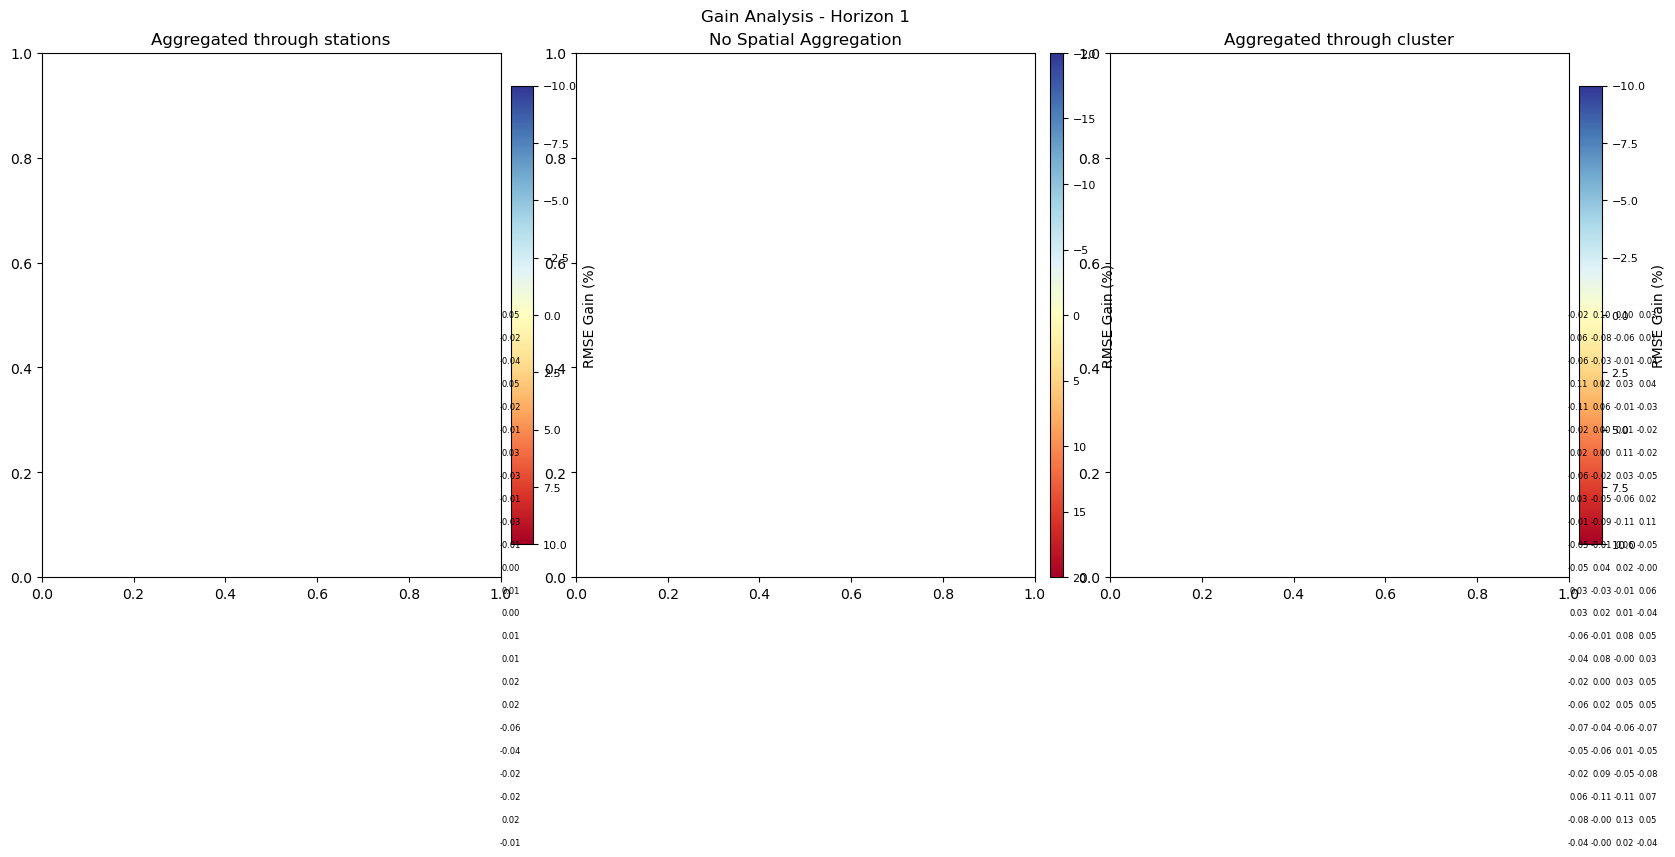

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- (Fonction utilitaire conservée telle quelle pour le contexte) ---
def get_df_mase_and_gains(df_error_station, index_matshow):
    df_gain21 = {}
    for column in stations: 
        gain_mase = temporal_agg_for_matshow(df_error_station, column, index_matshow, metric=None)
        df_gain21.update({column: gain_mase[column]})
    return df_gain21


def plot_coverage_matshow(data, x_labels = None, y_labels = None, log = False, 
                          cmap ="afmhot", save = None, cbar_label =  "Number of Data",bool_reversed=False
                          ,v_min=None,v_max=None,
                          display_values = False,
                          cbar_magic_args = False,
                          figsize = None,
                          title = None,
                          cax_cb = None,
                          ):
    # Def function to plot a df with matshow
    # Use : plot the coverage through week and days 
    if log : 
        data = np.log(data + 1)
    
    data[data == 0] = np.nan



    if figsize is not None:
        # matfig = plt.figure(figsize=figsize)
        # cax = plt.matshow(data.values, cmap=cmap,aspect='auto',fignum=matfig.number)  
        ax = plt.gca()
        cax = ax.imshow(data.values, cmap=cmap, aspect='auto', interpolation='nearest')
    else:
        cax = plt.matshow(data.values, cmap=cmap,fignum=False)  #

    #cmap_perso = plt.get_cmap(cmap)
    if bool_reversed: 
        cmap_perso =  plt.get_cmap(cmap).reversed()
    else: 
        cmap_perso =  plt.get_cmap(cmap)
    cmap_perso.set_bad('gray', 1.0)  

    cax.set_cmap(cmap_perso)
    if v_min is None:
        v_min=0.001
    if v_max is None:
        v_max=data.max().max()
    cax.set_clim(vmin=v_min, vmax=v_max)  


    #x labels
    if x_labels is None:
        x_labels = data.columns.values

    ax = plt.gca() 
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=85, fontsize=8)
    ax.xaxis.set_ticks_position('bottom')

    # Configuration des axes Y
    if y_labels is None: 
        y_labels = data.index.values
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=8)

    if cbar_magic_args :
        cbar = plt.colorbar(cax,fraction=0.046, pad=0.04)
    if cax_cb is None:
        divider = make_axes_locatable(ax)
        cax_cb = divider.append_axes("right", size="10%", pad=0.1)
    else:

        cbar = plt.colorbar(cax, cax=cax_cb)
    cbar.set_label(cbar_label) 

    if title is not None:
        ax.set_title(title)
    if display_values:
        for (i, j), val in np.ndenumerate(data.values):
            if not np.isnan(val):
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=6)

    if save is not None: 
            plt.savefig(save, format="pdf")


class ComparisonPlotter:
    """
    Class to plot the gain between two models with different temporal aggregations.
    Updated to force heatmaps to fill space and use a thin, dedicated colorbar axis.
    """
    def __init__(self, figsize_x=10, clustered_stations=None):
        self.figsize_x = figsize_x
        self.clustered_stations = clustered_stations 

    def _init_fig_axes_sizes(self, temporal_aggs):
        if self.clustered_stations is None: 
            nb_y_axes = 2
        else:
            nb_y_axes = 3

        width_ratios = WIDTH_RATIOS if self.clustered_stations is None else WIDTH_RATIOS_CLUSTER
        
        height_ratios = [1] * len(temporal_aggs)
        coef_y_size = 1

        if 'working_day_hour' in temporal_aggs:
            height_ratios[temporal_aggs.index('working_day_hour')] = 3
            coef_y_size += 2
        if 'weekday_hour_minute' in temporal_aggs:
            height_ratios[temporal_aggs.index('weekday_hour_minute')] = 8
            coef_y_size += 3

        gridspec_kw = {'width_ratios': width_ratios, 'height_ratios': height_ratios}
        local_figsize = (self.figsize_x, 6 * len(temporal_aggs) * coef_y_size * COEF_Y_SIZE)

        # On utilise constrained_layout=True pour gérer les marges globales, 
        # mais la colorbar sera gérée manuellement via make_axes_locatable
        self.fig, self.axes = plt.subplots(
            len(temporal_aggs), nb_y_axes, 
            figsize=local_figsize, 
            gridspec_kw=gridspec_kw,
            constrained_layout=True,
            squeeze=False
        )

    def _setup_ax_and_cax(self, ax):
        plt.sca(ax)
        # Création de l'axe de la colorbar à l'intérieur de l'espace du subplot
        divider = make_axes_locatable(ax)
        cax_cb = divider.append_axes("right", size=SIZE_COLORBAR, pad=PADDING)
        return cax_cb

    def _aggregated_plot(self, dic_gain21, metric, temporal_aggs, i):
        ax = self.axes[i, 0]
        cax_cb = self._setup_ax_and_cax(ax)

        plot_coverage_matshow(
            pd.DataFrame(pd.DataFrame(dic_gain21).mean(axis=1)),
            cmap='RdYlBu', save=None, 
            cbar_label=f'{metric.upper()} Gain (%)',
            bool_reversed=True, v_min=-10, v_max=10, display_values=True, 
            cax_cb=cax_cb 
        )
        ax.set_title(f"Aggregated through stations")

    def _plot_per_station(self, dic_gain21, metric, temporal_aggs, i):
        ax = self.axes[i, 1]
        cax_cb = self._setup_ax_and_cax(ax)

        if self.clustered_stations is None: 
            df_matshow = pd.DataFrame(dic_gain21)
        else:
            df_matshow = pd.DataFrame(dic_gain21)[list(itertools.chain.from_iterable([v for k,v in sorted(self.clustered_stations.items())]))]
            
        plot_coverage_matshow(
            df_matshow,
            cmap='RdYlBu', save=None, 
            cbar_label=f'{metric.upper()} Gain (%)',
            bool_reversed=True, v_min=-20, v_max=20, display_values=False, 
            cax_cb=cax_cb
        )
        ax.set_title(f"No Spatial Aggregation") 

    def _plot_per_cluster(self, dic_gain21, metric, temporal_aggs, i):
        if self.clustered_stations is not None: 
            ax = self.axes[i, 2]
            cax_cb = self._setup_ax_and_cax(ax)

            df_gain21 = pd.DataFrame(dic_gain21)
            df_gain_aggregated_per_cluster = pd.DataFrame(index=df_gain21.index)
            for cluster_id, station_list in sorted(self.clustered_stations.items()):
                df_gain_aggregated_per_cluster[cluster_id] = df_gain21[station_list].mean(axis=1)

            plot_coverage_matshow(
                df_gain_aggregated_per_cluster,
                cmap='RdYlBu', save=None, 
                cbar_label=f'{metric.upper()} Gain (%)',
                bool_reversed=True, v_min=-10, v_max=10, display_values=True, 
                cax_cb=cax_cb 
            )
            ax.set_title(f"Aggregated through cluster")


    def plot_gain_between_models_with_temporal_agg(self, stations, temporal_aggs,
                                                   step_ahead, bool_plot=True,
                                                   metric='RMSE'):
        self.figsize_x = max(fig_size_x, fig_size_y * len(stations))
        self.bool_plot = bool_plot

        self._init_fig_axes_sizes(temporal_aggs)

        for i, temporal_agg in enumerate(temporal_aggs):
            title = f"Average {metric.upper()} Gain(%) per {temporal_agg}"
            dic_gain21 = get_df_mase_and_gains(df_error_station, temporal_agg) # Assurez-vous que df_error_station est accessible

            self._aggregated_plot(dic_gain21, metric, temporal_aggs, i)
            self._plot_per_station(dic_gain21, metric, temporal_aggs, i)
            self._plot_per_cluster(dic_gain21, metric, temporal_aggs, i)
        
        self.fig.suptitle(f"Gain Analysis - Horizon {step_ahead}")


WIDTH_RATIOS = [1,1,1]
WIDTH_RATIOS_CLUSTER = [1,1,1]
# HEIGHT_RATIOS = [1]
temporal_aggs = ['hour']
COEF_Y_SIZE = 1
fig_size_x = 8
fig_size_y = 0.4
SIZE_COLORBAR = "5%"
PADDING = 0.1
stations = list(np.arange(N))
comparisonplotter = ComparisonPlotter(figsize_x=10,clustered_stations=clustered_stations)
comparisonplotter.plot_gain_between_models_with_temporal_agg(stations,temporal_aggs,step_ahead = H)